## **Heart Disease Prediction**

### __Importing Dataset__

The dataset was obtained from https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease. It is about the Key Heart Disease Indicators, sourced from the 2022 CDC survey involving over 400,000 adults, which primarily examines health-related factors that cause heart disease. Globally, heart disease ranks among the top causes of death across different racial groups, with major risk factors such as high blood pressure, high cholesterol levels, and smoking. Other significant contributors to heart disease include diabetes, obesity, lack of physical activity, and excessive alcohol consumption are taken into consideration. 

In [442]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import data_visualization as dv
import data_preprocessing as dp

In [443]:
#import the data
heart_disease_df=pd.read_csv("dataset/heart_2022_with_nans.csv")
heart_disease_df

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445127,Virgin Islands,Female,Good,0.0,3.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,No,...,1.65,69.85,25.63,NaN,Yes,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes
445128,Virgin Islands,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.70,83.01,28.66,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
445129,Virgin Islands,Female,Poor,30.0,30.0,5 or more years ago,No,5.0,1 to 5,No,...,1.70,49.90,17.23,NaN,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
445130,Virgin Islands,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,5.0,None of them,Yes,...,1.83,108.86,32.55,No,Yes,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes


In [444]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

We will use the same features based from the 2020 version of the dataset, which has 18 features, for simplification purposes. Hence, we'll be dropping the extra features found in 2022 dataset, with the exception for `HeightInMeters` and `WeightInKilograms` which are important when calculating missing values in `BMI`.

In [445]:
del_columns = ['State', 'LastCheckupTime', 'RemovedTeeth', 'HadDepressiveDisorder', 'HadArthritis', 'HadAngina', 'HadCOPD', 
               'DeafOrHardOfHearing', 'ECigaretteUsage', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'ChestScan',
               'DifficultyDressingBathing', 'DifficultyErrands', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'CovidPos',
               'TetanusLast10Tdap', 'HighRiskLastYear']

heart_disease_df = heart_disease_df.drop(columns=del_columns)
print(f"Number of features: {len(heart_disease_df.columns)}")

Number of features: 20


In [446]:
heart_disease_df.head()

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,SleepHours,HadHeartAttack,HadStroke,HadAsthma,HadSkinCancer,HadKidneyDisease,HadDiabetes,DifficultyWalking,SmokerStatus,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers
0,Female,Very good,0.0,0.0,No,8.0,No,No,No,No,No,Yes,No,Never smoked,"White only, Non-Hispanic",Age 80 or older,NaN,NaN,NaN,No
1,Female,Excellent,0.0,0.0,No,6.0,No,No,No,Yes,No,No,No,Never smoked,"White only, Non-Hispanic",Age 80 or older,1.60,68.04,26.57,No
2,Female,Very good,2.0,3.0,Yes,5.0,No,No,No,Yes,No,No,No,Never smoked,"White only, Non-Hispanic",Age 55 to 59,1.57,63.50,25.61,No
3,Female,Excellent,0.0,0.0,Yes,7.0,No,No,Yes,No,No,No,No,Current smoker - now smokes some days,"White only, Non-Hispanic",NaN,1.65,63.50,23.30,No
4,Female,Fair,2.0,0.0,Yes,9.0,No,No,No,No,No,No,No,Never smoked,"White only, Non-Hispanic",Age 40 to 44,1.57,53.98,21.77,Yes


### __Exploratory Data Analysis__

View the basic statistical details of the dataset

In [447]:
heart_disease_df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,434205.000000,436065.000000,439679.000000,416480.000000,403054.000000,396326.000000
mean,4.347919,4.382649,7.022983,1.702691,83.074470,28.529842
std,8.688912,8.387475,1.502425,0.107177,21.448173,6.554889
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.130000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,5.000000,8.000000,1.780000,95.250000,31.750000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


Drop all duplicate records from the dataset

In [448]:
print(f"Record count before dropping duplicates => {heart_disease_df.shape[0]}")
heart_disease_df = heart_disease_df.drop_duplicates()
print(f"Record count after dropping duplicates  => {heart_disease_df.shape[0]}")

Record count before dropping duplicates => 445132
Record count after dropping duplicates  => 431009


Check all records with missing (or null) values

In [449]:
print("List of features with missing values:")
for col in heart_disease_df.columns:
    null_values_count = heart_disease_df[col].isnull().sum()
    if null_values_count != 0:
        print(f"- '{col}' : {null_values_count}")


List of features with missing values:
- 'GeneralHealth' : 1175
- 'PhysicalHealthDays' : 10897
- 'MentalHealthDays' : 9038
- 'PhysicalActivities' : 1069
- 'SleepHours' : 5413
- 'HadHeartAttack' : 3038
- 'HadStroke' : 1530
- 'HadAsthma' : 1746
- 'HadSkinCancer' : 3116
- 'HadKidneyDisease' : 1899
- 'HadDiabetes' : 1060
- 'DifficultyWalking' : 19808
- 'SmokerStatus' : 31136
- 'RaceEthnicityCategory' : 13740
- 'AgeCategory' : 8444
- 'HeightInMeters' : 23814
- 'WeightInKilograms' : 36714
- 'BMI' : 43426
- 'AlcoholDrinkers' : 42185


There are 3,065 records with null values set for `HadHeartAttack`, which is the target variable. Hence, we can simply drop all those records, keeping only those with assigned class labels.

In [450]:
print(f"Record count before dropping null values in 'HadHeartAttack' => {heart_disease_df.shape[0]}")
heart_disease_df = heart_disease_df.dropna(subset=["HadHeartAttack"])
print(f"Record count after dropping null values in 'HadHeartAttack'  => {heart_disease_df.shape[0]}")


Record count before dropping null values in 'HadHeartAttack' => 431009
Record count after dropping null values in 'HadHeartAttack'  => 427971


Check if the target variable `HadHeartAttack` is a binary, wherein it should only have two distinct values, i.e. Yes and No. We will treat this feature as inidividuals with heart disease.

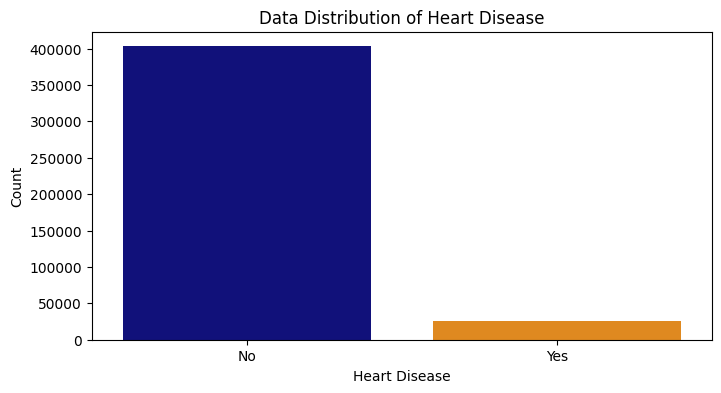

In [451]:
dv.show_bar_graph(df=heart_disease_df,
                  col_="HadHeartAttack",
                  figure_size=(8, 4),
                  title='Data Distribution of Heart Disease',
                  x_label='Heart Disease',
                  y_label='Count',
                  x_tick_rotation=None,
                  bar_color=['darkblue', 'darkorange'])

__Observation:__ The chart reveals that there is an imbalance in the number of records for `HadHeartAttack`, showing an uneven distribution of data between individuals who have the illness and those who do not. This could cause the trained model's predictions for heart disease to be severely biased. To balance the class distribution, we will use 

__insert the process details for balancing the class.....__

When building a model for heart disease, considering a particular ethnicity is very important because different ethnic groups can have distinct genetic, lifestyle, and environmental factors that influence the health of the heart. By focusing on a specific ethnicity, we can develop more personalized and accurate models that account for unique risk factors and characteristics within that population.

In [452]:
ethnicity_df = heart_disease_df["RaceEthnicityCategory"].value_counts(dropna=False).reset_index()
ethnicity_df.columns = ["RaceEthnicityCategory", "count"]

print(ethnicity_df)

           RaceEthnicityCategory   count
0       White only, Non-Hispanic  306097
1                       Hispanic   41980
2       Black only, Non-Hispanic   34793
3  Other race only, Non-Hispanic   22195
4                            NaN   13408
5      Multiracial, Non-Hispanic    9498


Therefore, we'll focus solely on the most number of records for racial group, which is `White only, Non-Hispanic`.

In [453]:
print(f"Record count before dropping null values in 'RaceEthnicityCategory' => {heart_disease_df.shape[0]}")
heart_disease_df = heart_disease_df[heart_disease_df['RaceEthnicityCategory'] == 'White only, Non-Hispanic']
print(f"Record count after filtering for 'White only, Non-Hispanic' in 'RaceEthnicityCategory' => {heart_disease_df.shape[0]}")

Record count before dropping null values in 'RaceEthnicityCategory' => 427971
Record count after filtering for 'White only, Non-Hispanic' in 'RaceEthnicityCategory' => 306097


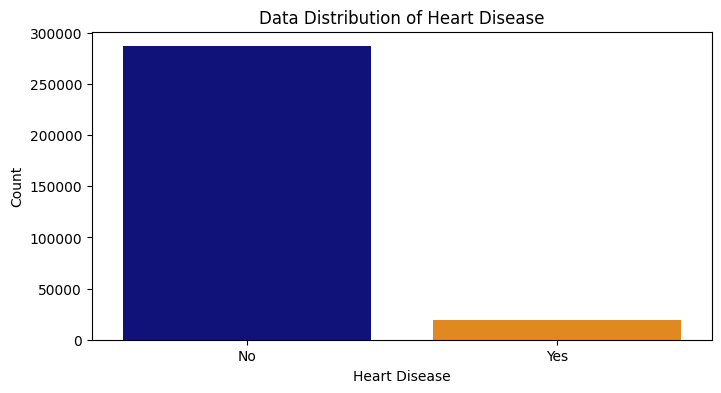

In [454]:
dv.show_bar_graph(df=heart_disease_df,
                  col_="HadHeartAttack",
                  figure_size=(8, 4),
                  title='Data Distribution of Heart Disease',
                  x_label='Heart Disease',
                  y_label='Count',
                  x_tick_rotation=None,
                  bar_color=['darkblue', 'darkorange'])

##### __Data Imputation for Missing Values:__

__a. Data Imputation for Height and Weight__

Check the skewness of `HeightInMeters` and `WeightInKilograms` within each age category to decide on the appropriate imputation method. Based from the results, majority of height values are slightly skewed to the left, while all weight values are skewed to the right. Therefore, __*median*__ imputation will be used to address the missing values in both height and weight as it is more sensitive to outliers than the mean.

__Skewness Interpretation:__
- If skewness is close to 0, it suggests a relatively symmetrical distribution.
- If skewness is significantly positive, it indicates a right-skewed distribution.
- If skewness is significantly negative, it indicates a left-skewed distribution.

In [455]:
# Replace null values in 'AgeCategory' with a placeholder value (e.g., 'Unknown')
heart_disease_df['AgeCategory'] = heart_disease_df['AgeCategory'].fillna('Unknown')

# Group by 'Sex' and 'AgeCategory' and calculate statistics
skewness_df = heart_disease_df.groupby(['Sex', 'AgeCategory']).agg({
    'HeightInMeters': ['skew', 'count', 'median'],
    'WeightInKilograms': ['skew', 'count', 'median']
}).reset_index()

# Rename columns for clarity
skewness_df.columns = ['Sex', 'AgeCategory', 'HeightSkewness', 'HeightCount', 'HeightMedian', 'WeightSkewness', 'WeightCount', 'WeightMedian']


print("Statistical analysis on height and weight based on sex and age category")
skewness_df


Statistical analysis on height and weight based on sex and age category


,Sex,AgeCategory,HeightSkewness,HeightCount,HeightMedian,WeightSkewness,WeightCount,WeightMedian
0,Female,Age 18 to 24,-0.013026,6069,1.65,1.351164,5876,66.68
1,Female,Age 25 to 29,0.067786,5478,1.65,1.261507,5301,72.57
2,Female,Age 30 to 34,0.110658,7095,1.65,1.351843,6792,72.57
3,Female,Age 35 to 39,0.100868,8395,1.65,1.390566,7973,73.94
4,Female,Age 40 to 44,-0.158525,9281,1.65,1.325938,8781,74.84
5,Female,Age 45 to 49,0.003126,9145,1.65,1.394839,8565,77.11
6,Female,Age 50 to 54,0.052254,11487,1.65,1.235800,10677,77.11
7,Female,Age 55 to 59,-0.090777,13170,1.65,1.136501,12179,74.84
8,Female,Age 60 to 64,-0.009026,16965,1.65,1.103589,15755,74.84
9,Female,Age 65 to 69,0.100167,18295,1.63,1.103935,16936,72.57


In [456]:
# Check for missing values
missing_val_height = heart_disease_df["HeightInMeters"].isnull().sum()
missing_val_weight = heart_disease_df["WeightInKilograms"].isnull().sum()
print(f"Check for missing values in `HeightInMeters` before imputation: {missing_val_height} and `WeightInKilograms` before imputation: {missing_val_weight}")

# Median imputation for Height and Weight
heart_disease_df = dp.impute_biometrics(heart_disease_df, skewness_df, "HeightInMeters", "HeightMedian")
heart_disease_df = dp.impute_biometrics(heart_disease_df, skewness_df, "WeightInKilograms", "WeightMedian")

# Check for missing values
missing_val_height = heart_disease_df["HeightInMeters"].isnull().sum()
missing_val_weight = heart_disease_df["WeightInKilograms"].isnull().sum()
print(f"Check for missing values in `HeightInMeters`: {missing_val_height} and `WeightInKilograms`: {missing_val_weight}")

Check for missing values in `HeightInMeters` before imputation: 12222 and `WeightInKilograms` before imputation: 23008
Check for missing values in `HeightInMeters`: 0 and `WeightInKilograms`: 0


In [457]:
heart_disease_df.isnull().sum()

Sex                          0
GeneralHealth              648
PhysicalHealthDays        6618
MentalHealthDays          5496
PhysicalActivities         649
SleepHours                2959
HadHeartAttack               0
HadStroke                  738
HadAsthma                  997
HadSkinCancer             2250
HadKidneyDisease          1068
HadDiabetes                397
DifficultyWalking        11360
SmokerStatus             18897
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms            0
BMI                      25968
AlcoholDrinkers          26077
dtype: int64

__b. Data Imputation for BMI__

Body Mass Index (BMI) is a metric calculated based on a person's weight and height. The BMI is often used as an indicator of body fatness and is a screening tool to categorize individuals into different weight status categories, such as underweight, normal weight, overweight, and obesity. The formula is:

$$ BMI = {WeightInKilograms \over HeightInMeters^2} $$

To fill in the missing BMI, we will calculate BMI for records with missing BMI but weight and height are available by using the given formula above.

In [458]:
print(f"Record count with missing BMI before data imputation => {heart_disease_df['BMI'].isnull().sum()}")

# Impute BMI values
heart_disease_df=dp.impute_bmi(heart_disease_df)

print(f"Record count with missing BMI after data imputation  => {heart_disease_df['BMI'].isnull().sum()}")

Record count with missing BMI before data imputation => 25968
Record count with missing BMI after data imputation  => 0


Use boxplot to check whether there are any outliers present in the BMI dataset. From the chart, a number of outliers are shown due to imbalance data distribution for people with heart disease. Hence, we'll just consider the data an outlier if BMI value is more than 120.

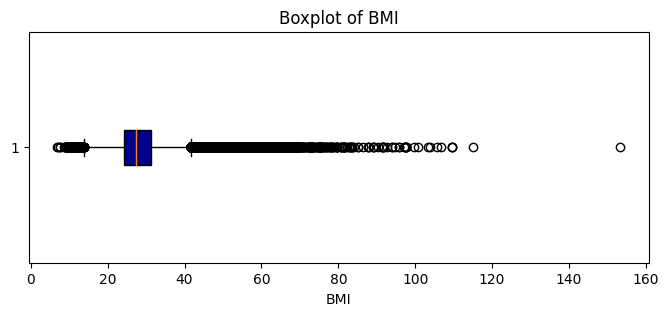

In [459]:
bmi_data = heart_disease_df['BMI'].dropna().tolist()
dv.show_boxplot_graph(data=bmi_data, figure_size=(8,3),title='Boxplot of BMI', x_label='BMI')

In [460]:
# Remove outliers from BMI dataset
heart_disease_df = heart_disease_df[heart_disease_df['BMI'] <= 120]

# Drop `HeightInMeters`, `WeightInKilograms` columns since they are correlated to BMI
columns_to_drop = ['HeightInMeters', 'WeightInKilograms']
heart_disease_df = heart_disease_df.drop(columns=columns_to_drop)

print(f"Columns: {heart_disease_df.columns}")

Columns: Index(['Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays',
       'PhysicalActivities', 'SleepHours', 'HadHeartAttack', 'HadStroke',
       'HadAsthma', 'HadSkinCancer', 'HadKidneyDisease', 'HadDiabetes',
       'DifficultyWalking', 'SmokerStatus', 'RaceEthnicityCategory',
       'AgeCategory', 'BMI', 'AlcoholDrinkers'],
      dtype='object')


__c. Data Imputation for Age Category__

To fill in the missing age group values, a new column named `WeightStatus` will be created first where its values will be derived from the BMI. The BMI interpretation is based on guidelines available at https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html." This new column will be part of the aggregation to get the age category with the highest count.

In [461]:
# Create a new column `WeightStatus` with values based on BMI
conditions = [
    (heart_disease_df['BMI'].between(0, 18.6)),
    (heart_disease_df['BMI'].between(18.6, 25.00)),
    (heart_disease_df['BMI'].between(25.0, 30.00)),
    (heart_disease_df['BMI'] >= 30.0)
]

choices = ["Underweight", "Healthy Weight", "Overweight", "Obesity"]

heart_disease_df['WeightStatus'] = np.select(conditions, choices)

# If needed, round the 'BMI' column to match the PySpark code
heart_disease_df['BMI'] = heart_disease_df['BMI'].round(2)

# Display the updated DataFrame
heart_disease_df.head()
    


,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,SleepHours,HadHeartAttack,HadStroke,HadAsthma,HadSkinCancer,HadKidneyDisease,HadDiabetes,DifficultyWalking,SmokerStatus,RaceEthnicityCategory,AgeCategory,BMI,AlcoholDrinkers,WeightStatus
0,Female,Very good,0.0,0.0,No,8.0,No,No,No,No,No,Yes,No,Never smoked,"White only, Non-Hispanic",Age 80 or older,25.52,No,Overweight
1,Female,Excellent,0.0,0.0,No,6.0,No,No,No,Yes,No,No,No,Never smoked,"White only, Non-Hispanic",Age 80 or older,26.57,No,Overweight
2,Female,Very good,2.0,3.0,Yes,5.0,No,No,No,Yes,No,No,No,Never smoked,"White only, Non-Hispanic",Age 55 to 59,25.61,No,Overweight
3,Female,Excellent,0.0,0.0,Yes,7.0,No,No,Yes,No,No,No,No,Current smoker - now smokes some days,"White only, Non-Hispanic",Unknown,23.30,No,Healthy Weight
4,Female,Fair,2.0,0.0,Yes,9.0,No,No,No,No,No,No,No,Never smoked,"White only, Non-Hispanic",Age 40 to 44,21.77,Yes,Healthy Weight


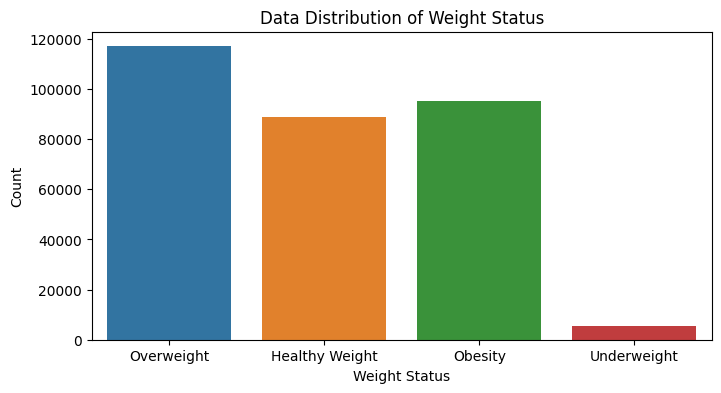

In [462]:
# # Show data distribution of weight status
dv.show_bar_graph(df=heart_disease_df, 
                  col_="WeightStatus", 
                  figure_size=(8,4),
                  title='Data Distribution of Weight Status', 
                  x_label='Weight Status', 
                  y_label='Count', 
                  x_tick_rotation=None)

Calculate the maximum count per `WeightStatus` category given the `AgeCategory`. Output are the `AgeCategory` values that will be imputed to missing age group given the weight status. 

*Example: Most females classified as underweight fall within the age category of 'Age 80 or older.' Hence, that age category value will be used to fill in the missing data for underweight females.*

In [463]:
print("Statistical analysis for age group based on sex and weight status")
age_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "WeightStatus", "AgeCategory")
age_result


Statistical analysis for age group based on sex and weight status


,Sex,WeightStatus,AgeCategory,count
12,Female,Healthy Weight,Age 80 or older,7613
23,Female,Obesity,Age 65 to 69,6036
37,Female,Overweight,Age 65 to 69,6927
54,Female,Underweight,Age 80 or older,710
56,Male,Healthy Weight,Age 18 to 24,4096
79,Male,Obesity,Age 65 to 69,5784
93,Male,Overweight,Age 65 to 69,7221
98,Male,Underweight,Age 18 to 24,401


In [464]:
#Converting the 'Unknown' values in AgeCategory column back to Null values
heart_disease_df['AgeCategory'] = heart_disease_df['AgeCategory'].replace('Unknown', np.nan)


Number of Null Values in AgeCategory before imputation:  4648
Number of Null Values in AgeCategory after imputation:  0


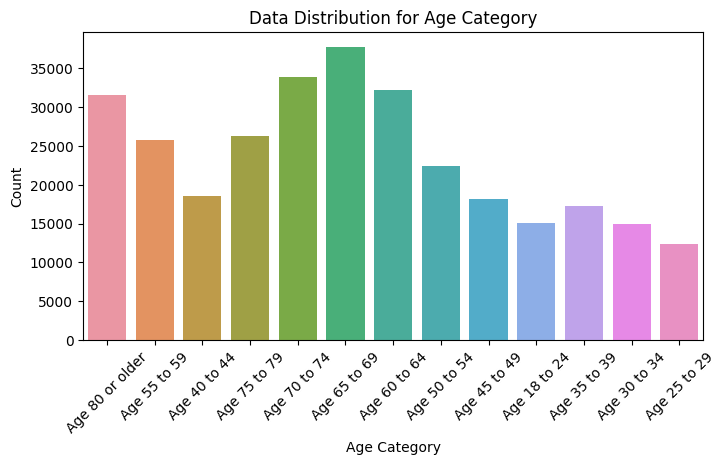

In [465]:
# Impute age category based on sex and weight status
print("Number of Null Values in AgeCategory before imputation: ", heart_disease_df['AgeCategory'].isnull().sum())
heart_disease_df = dp.impute_based_on_sws(heart_disease_df, age_result, "AgeCategory")
print("Number of Null Values in AgeCategory after imputation: ", heart_disease_df['AgeCategory'].isnull().sum())

# Show data distribution of age category
dv.show_bar_graph(df=heart_disease_df, 
                  col_="AgeCategory", 
                  figure_size=(8,4),
                  title='Data Distribution for Age Category', 
                  x_label='Age Category',
                  y_label='Count', 
                  x_tick_rotation=45)

__d. Data Imputation for General Health__

For each combination of Sex, WeightStatus, and GeneralHealth, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the GeneralHealth will be imputed based on the subgroup.

In [466]:
print("Statistical analysis for general health based on sex and weight status")
genhealth_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "WeightStatus", "GeneralHealth")
genhealth_result

Statistical analysis for general health based on sex and weight status


,Sex,WeightStatus,GeneralHealth,count
4,Female,Healthy Weight,Very good,21369
7,Female,Obesity,Good,19248
14,Female,Overweight,Very good,21937
19,Female,Underweight,Very good,1131
24,Male,Healthy Weight,Very good,12574
27,Male,Obesity,Good,18138
34,Male,Overweight,Very good,22833
37,Male,Underweight,Good,476


In [467]:
# Impute general health based on sex and weight status
print("Number of Null values in General Health before imputation: ", heart_disease_df['GeneralHealth'].isnull().sum())
heart_disease_df = dp.impute_based_on_sws(heart_disease_df, genhealth_result, "GeneralHealth")
print("Number of Null values in General Health after imputation: ", heart_disease_df['GeneralHealth'].isnull().sum())



Number of Null values in General Health before imputation:  648
Number of Null values in General Health after imputation:  0


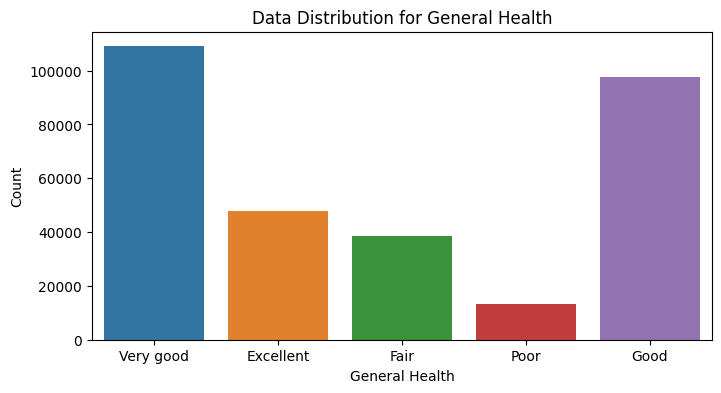

In [468]:
# Show data distribution of age category
dv.show_bar_graph(df=heart_disease_df, 
                  col_="GeneralHealth", 
                  figure_size=(8,4),
                  title='Data Distribution for General Health', 
                  x_label='General Health',
                  y_label='Count')

__e. Data Imputation for Having Diabetes__

For each combination of Sex, AgeCategory, and HadDiabetes, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the HadDiabetes will be imputed based on the subgroup. Based from the results below, all missing values will be replaced by 'No'.

In [469]:
print("Statistical analysis for having diabetes based on sex and age category")
diabetes_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadDiabetes")
diabetes_result

Statistical analysis for having diabetes based on sex and age category


,Sex,AgeCategory,HadDiabetes,count
0,Female,Age 18 to 24,No,6159
4,Female,Age 25 to 29,No,5465
8,Female,Age 30 to 34,No,6869
12,Female,Age 35 to 39,No,8022
16,Female,Age 40 to 44,No,8700
20,Female,Age 45 to 49,No,8452
24,Female,Age 50 to 54,No,10205
28,Female,Age 55 to 59,No,11423
32,Female,Age 60 to 64,No,14406
36,Female,Age 65 to 69,No,15815


Number of Null values in HadDiabetes before imputation:  397
Number of Null values in HadDiabetes after imputation:  0


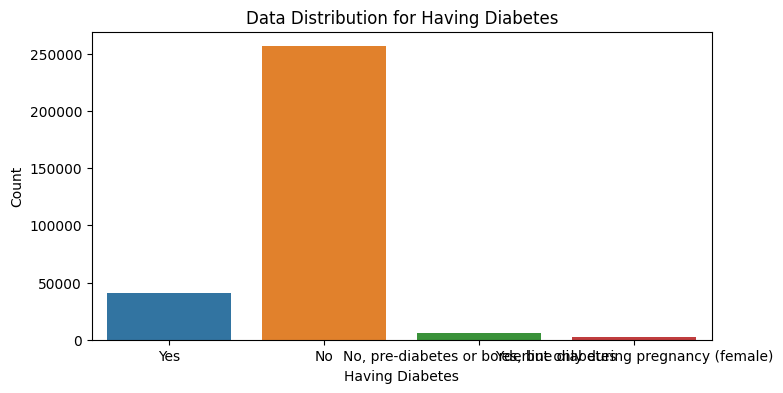

In [470]:
print("Number of Null values in HadDiabetes before imputation: ", heart_disease_df['HadDiabetes'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadDiabetes': 'No'})
print("Number of Null values in HadDiabetes after imputation: ", heart_disease_df['HadDiabetes'].isnull().sum())
# Show data distribution of having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadDiabetes", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Diabetes', 
                  x_label='Having Diabetes',
                  y_label='Count')

__f. Data Imputation for Having Stroke__

For each combination of Sex, AgeCategory, and HadStroke, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the HadStroke will be imputed based on the subgroup. Based from the results below, all missing values will be replaced by 'No'.

In [471]:
print("Statistical analysis for having stroke based on sex and age category")
stroke_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadStroke")
stroke_result

Statistical analysis for having stroke based on sex and age category


,Sex,AgeCategory,HadStroke,count
0,Female,Age 18 to 24,No,6327
2,Female,Age 25 to 29,No,5702
4,Female,Age 30 to 34,No,7366
6,Female,Age 35 to 39,No,8661
8,Female,Age 40 to 44,No,9499
10,Female,Age 45 to 49,No,9353
12,Female,Age 50 to 54,No,11622
14,Female,Age 55 to 59,No,13235
16,Female,Age 60 to 64,No,16837
18,Female,Age 65 to 69,No,18799


In [472]:
print("Number of Null values in HadStroke before imputation: ", heart_disease_df['HadStroke'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadStroke': 'No'})
print("Number of Null values in HadStroke after imputation: ", heart_disease_df['HadStroke'].isnull().sum())

Number of Null values in HadStroke before imputation:  738


Number of Null values in HadStroke after imputation:  0


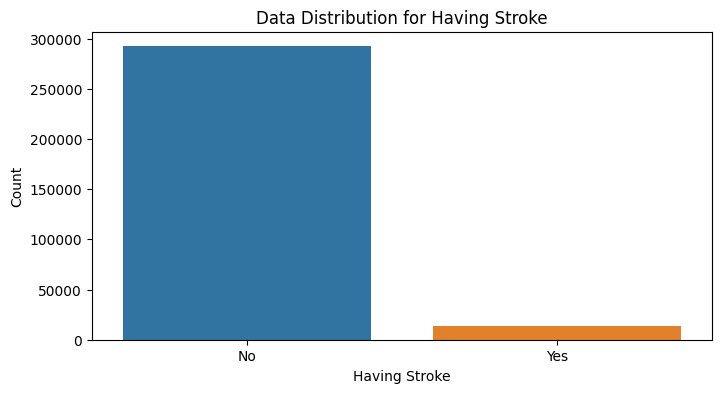

In [473]:
# Show data distribution of having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadStroke", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Stroke', 
                  x_label='Having Stroke',
                  y_label='Count')

__g. Data Imputation for Having Asthma__

For each combination of Sex, AgeCategory, and HadAsthma, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the HadAsthma will be imputed based on the subgroup. Based from the results below, all missing values will be replaced by 'No'.

In [474]:
print("Statistical analysis for having asthma based on sex and age category")
asthma_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadAsthma")
asthma_result

Statistical analysis for having asthma based on sex and age category


,Sex,AgeCategory,HadAsthma,count
0,Female,Age 18 to 24,No,4983
2,Female,Age 25 to 29,No,4462
4,Female,Age 30 to 34,No,5871
6,Female,Age 35 to 39,No,7052
8,Female,Age 40 to 44,No,7713
10,Female,Age 45 to 49,No,7583
12,Female,Age 50 to 54,No,9578
14,Female,Age 55 to 59,No,11138
16,Female,Age 60 to 64,No,14308
18,Female,Age 65 to 69,No,16276


In [475]:
print("Number of Null values in HadAsthma before imputation: ", heart_disease_df['HadAsthma'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadAsthma': 'No'})
print("Number of Null values in HadAsthma after imputation: ", heart_disease_df['HadAsthma'].isnull().sum())


Number of Null values in HadAsthma before imputation:  997


Number of Null values in HadAsthma after imputation:  0


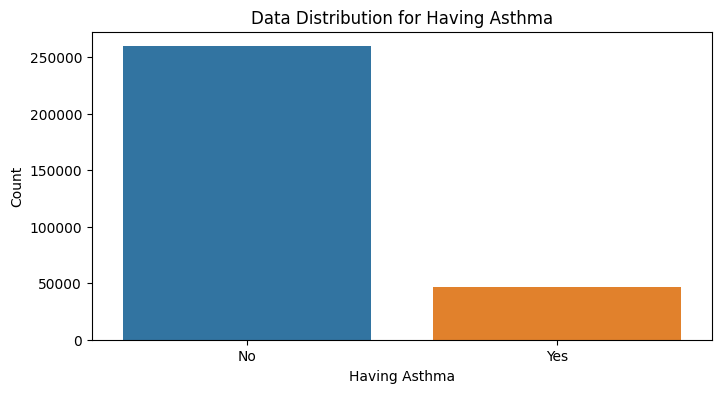

In [476]:
# Show data distribution of having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadAsthma", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Asthma', 
                  x_label='Having Asthma',
                  y_label='Count')

__h. Data Imputation for Having Skin Cancer__

For each combination of Sex, AgeCategory, and HadSkinCancer, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the HadSkinCancer will be imputed based on the subgroup. Based from the results below, all missing values will be replaced by 'No'.

In [477]:
print("Statistical analysis for having skin cancer based on sex and age category")
skin_cancer_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadSkinCancer")
skin_cancer_result

Statistical analysis for having skin cancer based on sex and age category


,Sex,AgeCategory,HadSkinCancer,count
0,Female,Age 18 to 24,No,6311
2,Female,Age 25 to 29,No,5700
4,Female,Age 30 to 34,No,7329
6,Female,Age 35 to 39,No,8582
8,Female,Age 40 to 44,No,9366
10,Female,Age 45 to 49,No,9144
12,Female,Age 50 to 54,No,11189
14,Female,Age 55 to 59,No,12491
16,Female,Age 60 to 64,No,15571
18,Female,Age 65 to 69,No,16977


In [478]:
print("Number of Null values in HadSkinCancer before imputation: ", heart_disease_df['HadSkinCancer'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadSkinCancer': 'No'})
print("Number of Null values in HadSkinCancer after imputation: ", heart_disease_df['HadSkinCancer'].isnull().sum())

Number of Null values in HadSkinCancer before imputation:  2250
Number of Null values in HadSkinCancer after imputation:  0


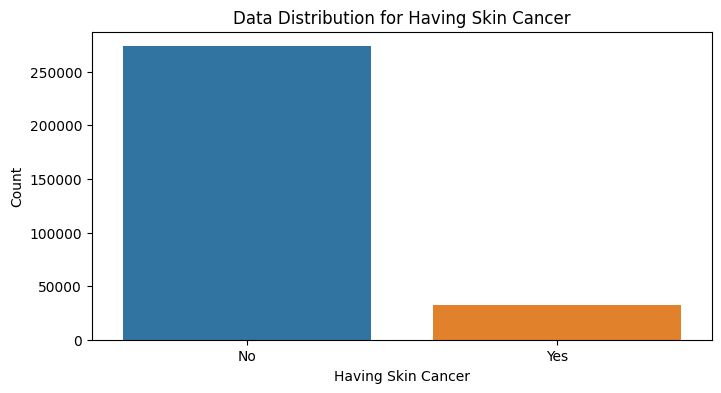

In [479]:
# Show data distribution of having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadSkinCancer", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Skin Cancer', 
                  x_label='Having Skin Cancer',
                  y_label='Count')

__i. Data Imputation for Having Kidney Disease__

For each combination of Sex, AgeCategory, and HadKidneyDisease, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the HadKidneyDisease will be imputed based on the subgroup. Based from the results below, all missing values will be replaced by 'No'.

In [480]:
print("Statistical analysis for having kidney disease based on sex and age category")
kidney_disease_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadKidneyDisease")
kidney_disease_result

Statistical analysis for having kidney disease based on sex and age category


,Sex,AgeCategory,HadKidneyDisease,count
0,Female,Age 18 to 24,No,6287
2,Female,Age 25 to 29,No,5676
4,Female,Age 30 to 34,No,7303
6,Female,Age 35 to 39,No,8609
8,Female,Age 40 to 44,No,9465
10,Female,Age 45 to 49,No,9319
12,Female,Age 50 to 54,No,11595
14,Female,Age 55 to 59,No,13126
16,Female,Age 60 to 64,No,16717
18,Female,Age 65 to 69,No,18577


In [481]:
print("Number of Null values in HadkidneyDisease before imputation: ", heart_disease_df['HadKidneyDisease'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'HadKidneyDisease': 'No'})
print("Number of Null values in HadkidneyDisease after imputation: ", heart_disease_df['HadKidneyDisease'].isnull().sum())


Number of Null values in HadkidneyDisease before imputation:  1068


Number of Null values in HadkidneyDisease after imputation:  0


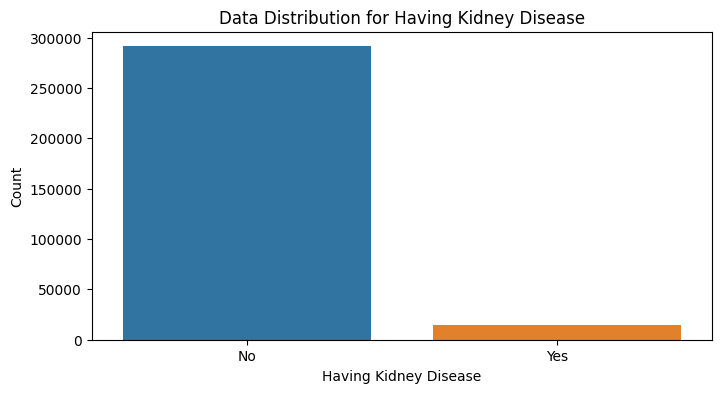

In [482]:
# Show data distribution of having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadKidneyDisease", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Kidney Disease', 
                  x_label='Having Kidney Disease',
                  y_label='Count')

__j. Data Imputation for Smoking Status__

For each combination of Sex, AgeCategory, and SmokerStatus, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the SmokerStatus will be imputed based on the subgroup. Based from the results below, individuals aged 75 and above who are male are mostly former smokers. Other groups indicate that there is no history of smoking.

In [483]:
print("Statistical analysis for smoker status based on sex and age category")
smoker_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "SmokerStatus")
smoker_result

Statistical analysis for smoker status based on sex and age category


,Sex,AgeCategory,SmokerStatus,count
3,Female,Age 18 to 24,Never smoked,5203
7,Female,Age 25 to 29,Never smoked,4007
11,Female,Age 30 to 34,Never smoked,4599
15,Female,Age 35 to 39,Never smoked,5085
19,Female,Age 40 to 44,Never smoked,5004
23,Female,Age 45 to 49,Never smoked,5141
27,Female,Age 50 to 54,Never smoked,6618
31,Female,Age 55 to 59,Never smoked,7182
35,Female,Age 60 to 64,Never smoked,8840
39,Female,Age 65 to 69,Never smoked,10436


In [484]:
print("Number of Null values in SmokerStatus before imputation: ", heart_disease_df['SmokerStatus'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = dp.impute_smoking_status(heart_disease_df)
print("Number of Null values in SmokerStatus after imputation: ", heart_disease_df['SmokerStatus'].isnull().sum())



Number of Null values in SmokerStatus before imputation:  18896
Number of Null values in SmokerStatus after imputation:  0


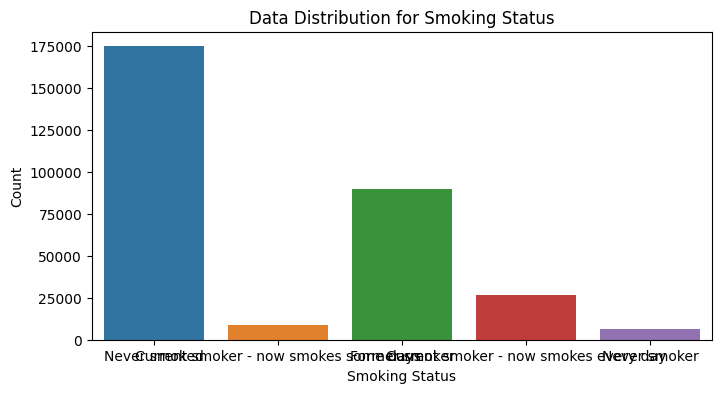

In [485]:
# Show data distribution of having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="SmokerStatus", 
                  figure_size=(8,4),
                  title='Data Distribution for Smoking Status', 
                  x_label='Smoking Status',
                  y_label='Count')

__k. Data Imputation for Alcohol Drinker__

For each combination of Sex, AgeCategory, and AlcoholDrinkers, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the AlcoholDrinkers will be imputed based on the subgroup.

In [486]:
print("Statistical analysis for alcohol drinker based on sex and age category")
alcohol_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "AlcoholDrinkers")
alcohol_result

Statistical analysis for alcohol drinker based on sex and age category


,Sex,AgeCategory,AlcoholDrinkers,count
1,Female,Age 18 to 24,Yes,3398
3,Female,Age 25 to 29,Yes,3384
5,Female,Age 30 to 34,Yes,4143
7,Female,Age 35 to 39,Yes,4899
9,Female,Age 40 to 44,Yes,5353
11,Female,Age 45 to 49,Yes,5123
13,Female,Age 50 to 54,Yes,6307
15,Female,Age 55 to 59,Yes,6808
17,Female,Age 60 to 64,Yes,8358
18,Female,Age 65 to 69,No,9418


In [487]:
print("Number of Null values in AlcoholDrinkers before imputation: ", heart_disease_df['AlcoholDrinkers'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = dp.impute_alcohol_drinker(heart_disease_df)
print("Number of Null values in AlcoholDrinkers after imputation: ", heart_disease_df['AlcoholDrinkers'].isnull().sum())

Number of Null values in AlcoholDrinkers before imputation:  26076


Number of Null values in AlcoholDrinkers after imputation:  0


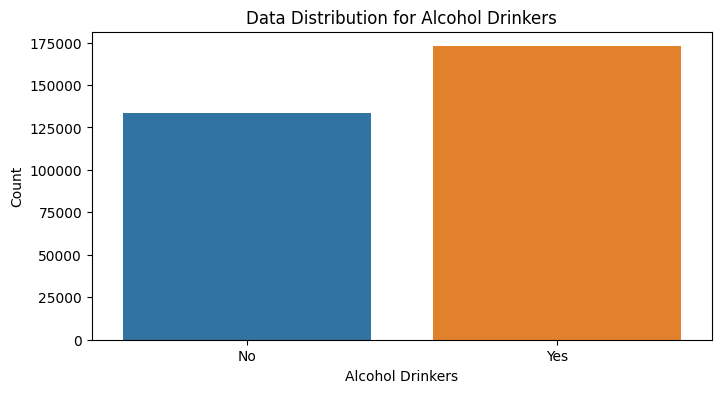

In [488]:

# Show data distribution of having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="AlcoholDrinkers", 
                  figure_size=(8,4),
                  title='Data Distribution for Alcohol Drinkers', 
                  x_label='Alcohol Drinkers',
                  y_label='Count')

__i. Data Imputation for Physically Active__

For each combination of Sex, AgeCategory, and PhysicalActivities, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the PhysicalActivities will be imputed based on the subgroup. Based from the results below, all missing values will be replaced by 'Yes'.

In [489]:
print("Statistical analysis for physicallly active group based on sex and age category")
phyactive_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "PhysicalActivities")
phyactive_result

Statistical analysis for physicallly active group based on sex and age category


,Sex,AgeCategory,PhysicalActivities,count
1,Female,Age 18 to 24,Yes,5448
3,Female,Age 25 to 29,Yes,4891
5,Female,Age 30 to 34,Yes,6223
7,Female,Age 35 to 39,Yes,7396
9,Female,Age 40 to 44,Yes,7892
11,Female,Age 45 to 49,Yes,7536
13,Female,Age 50 to 54,Yes,9165
15,Female,Age 55 to 59,Yes,10283
17,Female,Age 60 to 64,Yes,13115
19,Female,Age 65 to 69,Yes,14577


In [490]:
print("Number of Null values in PhysicalActivities before imputation: ", heart_disease_df['PhysicalActivities'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'PhysicalActivities': 'Yes'})
print("Number of Null values in PhysicalActivities after imputation: ", heart_disease_df['PhysicalActivities'].isnull().sum())

Number of Null values in PhysicalActivities before imputation:  649


Number of Null values in PhysicalActivities after imputation:  0


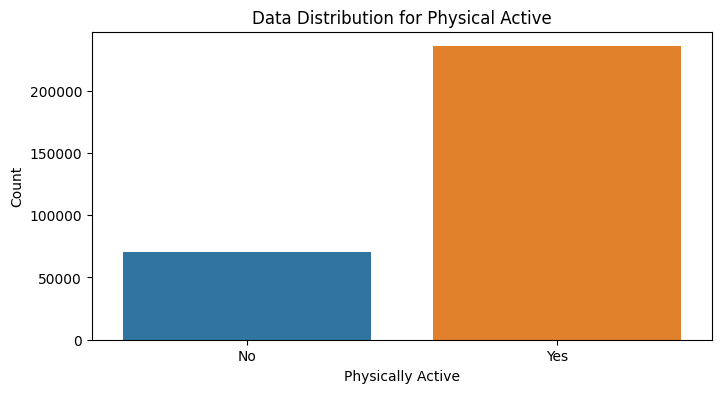

In [491]:
# Show data distribution of having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="PhysicalActivities", 
                  figure_size=(8,4),
                  title='Data Distribution for Physical Active', 
                  x_label='Physically Active',
                  y_label='Count')

__m. Data Imputation for Difficulty Walking__

For each combination of Sex, AgeCategory, and DifficultyWalking, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the DifficultyWalking will be imputed based on the subgroup. Based from the results below, all missing values will be replaced by 'Yes'.

In [492]:
print("Statistical analysis for difficulty of walking based on sex and age category")
diffwalking_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "DifficultyWalking")
diffwalking_result

Statistical analysis for difficulty of walking based on sex and age category


,Sex,AgeCategory,DifficultyWalking,count
0,Female,Age 18 to 24,No,5867
2,Female,Age 25 to 29,No,5302
4,Female,Age 30 to 34,No,6802
6,Female,Age 35 to 39,No,7953
8,Female,Age 40 to 44,No,8585
10,Female,Age 45 to 49,No,8225
12,Female,Age 50 to 54,No,9878
14,Female,Age 55 to 59,No,10841
16,Female,Age 60 to 64,No,13673
18,Female,Age 65 to 69,No,15203


In [493]:
print("Number of Null values in DifficultyWalking before imputation: ", heart_disease_df['DifficultyWalking'].isnull().sum())
# Imput all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'DifficultyWalking': 'No'})
print("Number of Null values in DifficultyWalking after imputation: ", heart_disease_df['DifficultyWalking'].isnull().sum())

Number of Null values in DifficultyWalking before imputation:  11359


Number of Null values in DifficultyWalking after imputation:  0


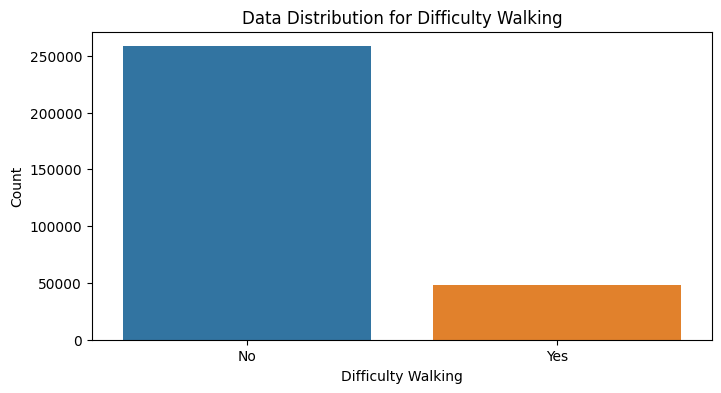

In [494]:

# Show data distribution of having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="DifficultyWalking", 
                  figure_size=(8,4),
                  title='Data Distribution for Difficulty Walking', 
                  x_label='Difficulty Walking',
                  y_label='Count')

__xiii. Data Imputation for Physical and Mental Health Days__

Based from the results below, all missing values in PhysicalHealthDays will be replaced by '0'.

In [495]:
print("Statistical analysis for physical health days based on sex and age category")
phyhealthdays_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "PhysicalHealthDays")
phyhealthdays_result

Statistical analysis for physical health days based on sex and age category


,Sex,AgeCategory,PhysicalHealthDays,count
0,Female,Age 18 to 24,0.0,3249
31,Female,Age 25 to 29,0.0,3135
61,Female,Age 30 to 34,0.0,3968
92,Female,Age 35 to 39,0.0,4847
121,Female,Age 40 to 44,0.0,5329
152,Female,Age 45 to 49,0.0,5203
183,Female,Age 50 to 54,0.0,6534
214,Female,Age 55 to 59,0.0,7508
245,Female,Age 60 to 64,0.0,9682
276,Female,Age 65 to 69,0.0,11283


In [496]:
print("Number of Null values in PhysicalHealthDays before imputation: ", heart_disease_df['PhysicalHealthDays'].isnull().sum())
# Impute all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'PhysicalHealthDays': 0})
print("Number of Null values in PhysicalHealthDays after imputation: ", heart_disease_df['PhysicalHealthDays'].isnull().sum())


Number of Null values in PhysicalHealthDays before imputation:  6618
Number of Null values in PhysicalHealthDays after imputation:  0


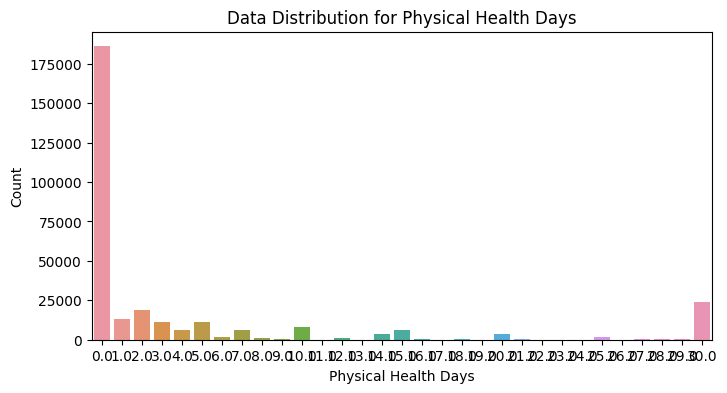

In [497]:
# Show data distribution for physical health days
dv.show_bar_graph(df=heart_disease_df, 
                  col_="PhysicalHealthDays", 
                  figure_size=(8,4),
                  title='Data Distribution for Physical Health Days', 
                  x_label='Physical Health Days',
                  y_label='Count')

Based from the results below, all missing values in MentalHealthDays will be replaced by '0'.

In [498]:
print("Statistical analysis for mental health days based on sex and age category")
menhealthdays_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "MentalHealthDays")
menhealthdays_result

Statistical analysis for mental health days based on sex and age category


,Sex,AgeCategory,MentalHealthDays,count
0,Female,Age 18 to 24,0.0,1204
31,Female,Age 25 to 29,0.0,1442
62,Female,Age 30 to 34,0.0,2219
93,Female,Age 35 to 39,0.0,3024
124,Female,Age 40 to 44,0.0,3754
155,Female,Age 45 to 49,0.0,4093
184,Female,Age 50 to 54,0.0,5590
215,Female,Age 55 to 59,0.0,6979
244,Female,Age 60 to 64,0.0,9977
275,Female,Age 65 to 69,0.0,12132


In [499]:
print("Number of Null values in MentalHealthDays before imputation: ", heart_disease_df['MentalHealthDays'].isnull().sum())
# Impute all missing values with 'No' for all sex and age category
heart_disease_df = heart_disease_df.fillna({'MentalHealthDays': 0})
print("Number of Null values in MentalHealthDays after imputation: ", heart_disease_df['MentalHealthDays'].isnull().sum())

Number of Null values in MentalHealthDays before imputation:  5496
Number of Null values in MentalHealthDays after imputation:  0


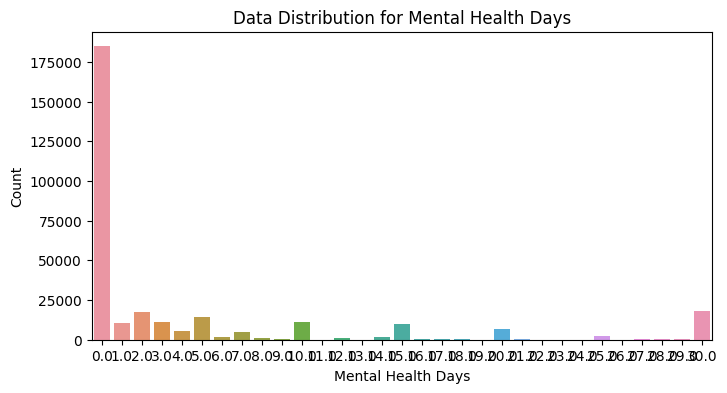

In [500]:
# Show data distribution for mental health days
dv.show_bar_graph(df=heart_disease_df, 
                  col_="MentalHealthDays", 
                  figure_size=(8,4),
                  title='Data Distribution for Mental Health Days', 
                  x_label='Mental Health Days',
                  y_label='Count')

__xiv. Data Imputation for Sleeping Hours__

Based from the results below, individuals aged 65 years and older have an average sleep duration of 8 hours, while other age groups typically sleep for seven hours on average.

In [501]:
print("Statistical analysis for sleep hours based on sex and age category")
menhealthdays_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "SleepHours")
menhealthdays_result

Statistical analysis for sleep hours based on sex and age category


,Sex,AgeCategory,SleepHours,count
6,Female,Age 18 to 24,7.0,1902
24,Female,Age 25 to 29,7.0,1817
41,Female,Age 30 to 34,7.0,2313
60,Female,Age 35 to 39,7.0,2968
77,Female,Age 40 to 44,7.0,3241
95,Female,Age 45 to 49,7.0,3198
115,Female,Age 50 to 54,7.0,3852
136,Female,Age 55 to 59,7.0,4438
158,Female,Age 60 to 64,7.0,5584
178,Female,Age 65 to 69,8.0,6106


In [502]:
print("Number of Null values in SleepHours before imputation: ", heart_disease_df['SleepHours'].isnull().sum())
# Impute sleep hours based on sex and weight status
heart_disease_df = dp.impute_sleep_hours(heart_disease_df)
print("Number of Null values in SleepHours after imputation: ", heart_disease_df['SleepHours'].isnull().sum())

Number of Null values in SleepHours before imputation:  2959
Number of Null values in SleepHours after imputation:  0


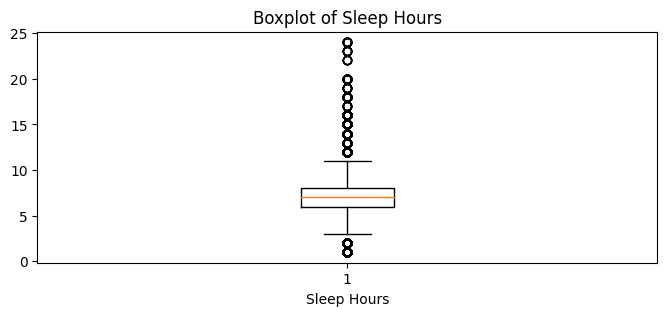

In [503]:
sleep_hours=heart_disease_df['SleepHours'].tolist()
sleep_hours = pd.to_numeric(sleep_hours, errors='coerce')

# Create a boxplot using Matplotlib
plt.figure(figsize=(8, 3))
plt.boxplot(sleep_hours)
plt.title('Boxplot of Sleep Hours')
plt.xlabel('Sleep Hours')

# Show the plot
plt.show()

We will eliminate any outliers present in the dataset to enhance the accuracy and reliability of our analysis.

In [504]:
# Filter the DataFrame
heart_disease_df = heart_disease_df[(heart_disease_df['SleepHours'] >= 3) & (heart_disease_df['SleepHours'] <= 11)]

# Calculate min and max sleep hours
min_sleep_hours = heart_disease_df['SleepHours'].min()
max_sleep_hours = heart_disease_df['SleepHours'].max()

# Display the result
print(f"Min Sleep Hours: {min_sleep_hours}, Max Sleep Hours: {max_sleep_hours}")

Min Sleep Hours: 3.0, Max Sleep Hours: 11.0


Remove redundant features, i.e. WeightStatus, HeightInMeters, WeightInKilograms, as they are solely utilized for BMI calculation and imputation of the person's age category and general health. Furthermore, given that we restrict the RaceEthnicityCategory to 'White only, Non-Hispanic', we will exclude this feature from consideration since it contains only a one value.

In [505]:
# Drop specified columns
columns_to_drop = ['WeightStatus', 'RaceEthnicityCategory']
heart_disease_df = heart_disease_df.drop(columns=columns_to_drop)

# Display the remaining columns
print(f"Columns: {heart_disease_df.columns}")

Columns: Index(['Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays',
       'PhysicalActivities', 'SleepHours', 'HadHeartAttack', 'HadStroke',
       'HadAsthma', 'HadSkinCancer', 'HadKidneyDisease', 'HadDiabetes',
       'DifficultyWalking', 'SmokerStatus', 'AgeCategory', 'BMI',
       'AlcoholDrinkers'],
      dtype='object')


In [506]:
heart_disease_df.head()

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,SleepHours,HadHeartAttack,HadStroke,HadAsthma,HadSkinCancer,HadKidneyDisease,HadDiabetes,DifficultyWalking,SmokerStatus,AgeCategory,BMI,AlcoholDrinkers
0,Female,Very good,0.0,0.0,No,8.0,No,No,No,No,No,Yes,No,Never smoked,Age 80 or older,25.52,No
1,Female,Excellent,0.0,0.0,No,6.0,No,No,No,Yes,No,No,No,Never smoked,Age 80 or older,26.57,No
2,Female,Very good,2.0,3.0,Yes,5.0,No,No,No,Yes,No,No,No,Never smoked,Age 55 to 59,25.61,No
3,Female,Excellent,0.0,0.0,Yes,7.0,No,No,Yes,No,No,No,No,Current smoker - now smokes some days,Age 80 or older,23.30,No
4,Female,Fair,2.0,0.0,Yes,9.0,No,No,No,No,No,No,No,Never smoked,Age 40 to 44,21.77,Yes


### __Balancing Data Distribution of Target Feature__

### __Feature Selection and Feature Engineering__

In [507]:
categorical_columns=['Sex','GeneralHealth','PhysicalActivities','HadHeartAttack','HadStroke','HadAsthma','HadSkinCancer','HadKidneyDisease','HadDiabetes','DifficultyWalking','SmokerStatus','AgeCategory','AlcoholDrinkers']
numerical_columns=['PhysicalHealthDays','MentalHealthDays','SleepHours','BMI']
heart_disease_df[numerical_columns] = heart_disease_df[numerical_columns].apply(pd.to_numeric, errors='coerce')

In [508]:
#Standardize the numerical features
scaler = StandardScaler()
heart_disease_df[numerical_columns]=scaler.fit_transform(heart_disease_df[numerical_columns])
heart_disease_df.head()

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,SleepHours,HadHeartAttack,HadStroke,HadAsthma,HadSkinCancer,HadKidneyDisease,HadDiabetes,DifficultyWalking,SmokerStatus,AgeCategory,BMI,AlcoholDrinkers
0,Female,Very good,-0.498796,-0.517804,No,0.763382,No,No,No,No,No,Yes,No,Never smoked,Age 80 or older,-0.447397,No
1,Female,Excellent,-0.498796,-0.517804,No,-0.847507,No,No,No,Yes,No,No,No,Never smoked,Age 80 or older,-0.279739,No
2,Female,Very good,-0.266234,-0.151790,Yes,-1.652952,No,No,No,Yes,No,No,No,Never smoked,Age 55 to 59,-0.433026,No
3,Female,Excellent,-0.498796,-0.517804,Yes,-0.042063,No,No,Yes,No,No,No,No,Current smoker - now smokes some days,Age 80 or older,-0.801874,No
4,Female,Fair,-0.266234,-0.517804,Yes,1.568826,No,No,No,No,No,No,No,Never smoked,Age 40 to 44,-1.046176,Yes


In [509]:
# Create dummy variables
heart_disease_df_dummy = pd.get_dummies(heart_disease_df, columns=categorical_columns, drop_first=True)
heart_disease_df_dummy

,PhysicalHealthDays,MentalHealthDays,SleepHours,BMI,Sex_Male,GeneralHealth_Fair,GeneralHealth_Good,GeneralHealth_Poor,GeneralHealth_Very good,PhysicalActivities_Yes,...,AgeCategory_Age 40 to 44,AgeCategory_Age 45 to 49,AgeCategory_Age 50 to 54,AgeCategory_Age 55 to 59,AgeCategory_Age 60 to 64,AgeCategory_Age 65 to 69,AgeCategory_Age 70 to 74,AgeCategory_Age 75 to 79,AgeCategory_Age 80 or older,AlcoholDrinkers_Yes
0,-0.498796,-0.517804,0.763382,-0.447397,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,-0.498796,-0.517804,-0.847507,-0.279739,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-0.266234,-0.151790,-1.652952,-0.433026,0,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
3,-0.498796,-0.517804,-0.042063,-0.801874,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,-0.266234,-0.517804,1.568826,-1.046176,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445099,-0.498796,0.092220,0.763382,-1.504442,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1
445117,-0.498796,-0.517804,-0.847507,0.632002,1,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1
445119,-0.498796,-0.517804,-0.042063,-1.751937,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,1
445120,-0.498796,-0.517804,-0.847507,-0.524041,1,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1


In [510]:
heart_disease_df_dummy.columns

Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'BMI',
       'Sex_Male', 'GeneralHealth_Fair', 'GeneralHealth_Good',
       'GeneralHealth_Poor', 'GeneralHealth_Very good',
       'PhysicalActivities_Yes', 'HadHeartAttack_Yes', 'HadStroke_Yes',
       'HadAsthma_Yes', 'HadSkinCancer_Yes', 'HadKidneyDisease_Yes',
       'HadDiabetes_No, pre-diabetes or borderline diabetes',
       'HadDiabetes_Yes',
       'HadDiabetes_Yes, but only during pregnancy (female)',
       'DifficultyWalking_Yes',
       'SmokerStatus_Current smoker - now smokes some days',
       'SmokerStatus_Former smoker', 'SmokerStatus_Never smoked',
       'SmokerStatus_Never smoker', 'AgeCategory_Age 25 to 29',
       'AgeCategory_Age 30 to 34', 'AgeCategory_Age 35 to 39',
       'AgeCategory_Age 40 to 44', 'AgeCategory_Age 45 to 49',
       'AgeCategory_Age 50 to 54', 'AgeCategory_Age 55 to 59',
       'AgeCategory_Age 60 to 64', 'AgeCategory_Age 65 to 69',
       'AgeCategory_Age 70 to 74', 'AgeCatego

### __Model Creation and Evaluation__

In [511]:
#Split into feature variable and target variable
X=heart_disease_df_dummy.drop(columns='HadHeartAttack_Yes')
y=heart_disease_df_dummy['HadHeartAttack_Yes']


In [512]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Count the class distribution before SMOTE
class_distribution_before = y_train.value_counts()
# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

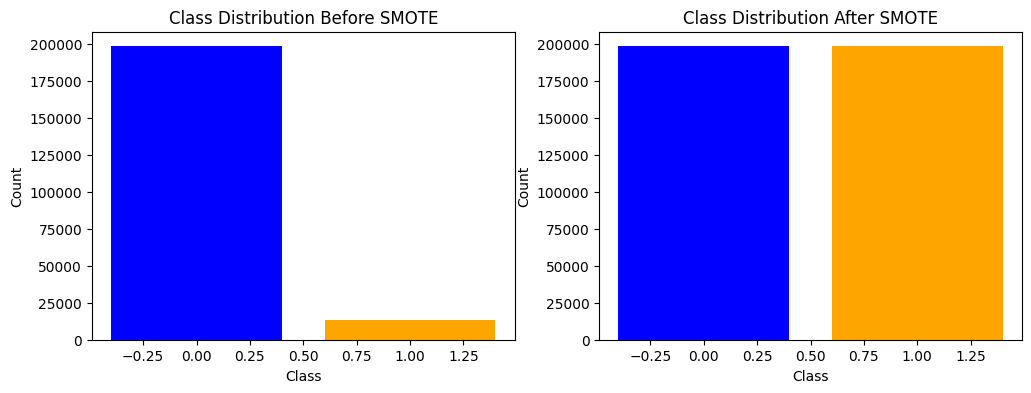

In [513]:
# Count the class distribution after SMOTE
class_distribution_after = pd.Series(y_resampled).value_counts()

# Plotting the class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before SMOTE
axes[0].bar(class_distribution_before.index, class_distribution_before.values, color=['blue', 'orange'])
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# After SMOTE
axes[1].bar(class_distribution_after.index, class_distribution_after.values, color=['blue', 'orange'])
axes[1].set_title('Class Distribution After SMOTE')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.show()

##### Logistic Regression

In [514]:
LR_model=LogisticRegression()
LR_model.fit(X_resampled,y_resampled)

y_pred_LR=LR_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_LR))
print("\nClassification Report:\n", classification_report(y_test, y_pred_LR))

Confusion Matrix:
 [[60652 24334]
 [ 1889  3700]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.71      0.82     84986
           1       0.13      0.66      0.22      5589

    accuracy                           0.71     90575
   macro avg       0.55      0.69      0.52     90575
weighted avg       0.92      0.71      0.79     90575



c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### Decision Tree

##### Random Forests

In [515]:
RF_model = RandomForestClassifier(random_state=42)
RF_model.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_RF = RF_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_RF))
print("Classification Report:")
print(classification_report(y_test, y_pred_RF))

Confusion Matrix:
 [[78599  6387]
 [ 4434  1155]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     84986
           1       0.15      0.21      0.18      5589

    accuracy                           0.88     90575
   macro avg       0.55      0.57      0.56     90575
weighted avg       0.90      0.88      0.89     90575



##### Gradient Boosted Tree

### __Hyper Parameter Tuning__

### __References__

- https://towardsdatascience.com/apache-spark-performance-boosting-e072a3ec1179
- https://medium.com/@adrianchang/apache-spark-checkpointing-ebd2ec065371